
# Natural Language Processing with Disaster Tweets 

- **GitHub Repository:** *https://github.com/shaikh23/NLP-disaster-tweets*  


## Executive Summary

This project classifies tweets as **disaster‑related (1)** or **not (0)**.  
Metrics are evaluated on Kaggle with **F1 score**, which balances precision and recall — important when classes can be imbalanced and the cost of false alarms vs. misses both matter.

I implement and compare:
1. **Classical NLP:** TF‑IDF + Logistic Regression  
2. **Neural NLP (RNN family):** Tokenizer → Embedding → **BiLSTM/BiGRU** with early stopping


In [1]:

# Imports
import os, re, html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks, optimizers

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Matplotlib default settings (no external styles)
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["axes.grid"] = True

# Kaggle vs local paths
KAGGLE_DATA = "/kaggle/input/nlp-getting-started"
LOCAL_DATA = "./data"  # if you download the CSVs locally, put them in ./data
GLOVE_DIRS = [
    "/kaggle/input/glove6b100dtxt",     # common Kaggle dataset name
    "/kaggle/input/glove-6b-100d",      # alternative
    "./data"                            # local fallback
]

print("TensorFlow:", tf.__version__)


2025-09-18 18:56:50.201672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758221810.438514      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758221810.510796      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow: 2.18.0



## 1. Problem & Data Description 

- **Task:** Binary text classification — predict whether a tweet describes a real disaster (**1**) or not (**0**).
- **Data:** ~10k labeled tweets for training; a test set for submission.
- **Target:** `target` (0/1).  
- **Inputs:** `text`, plus optional features like `keyword` and `location` which may contain useful signal (sometimes noisy).
- **Metric:** **F1 score** on the test set (Kaggle private leaderboard).

I will:
- Inspect class balance and text length distributions.
- Clean and normalize text minimally but carefully to preserve signal (hashtags, negations, etc.).
- Compare a **TF‑IDF + Logistic Regression** baseline with an **RNN‑based** model (BiLSTM/BiGRU) using Keras.


In [2]:

# 2. Load Data
def load_competition_data():
    # Try Kaggle path first
    if os.path.exists(os.path.join(KAGGLE_DATA, "train.csv")):
        train_path = os.path.join(KAGGLE_DATA, "train.csv")
        test_path  = os.path.join(KAGGLE_DATA, "test.csv")
    else:
        # Fallback to local
        train_path = os.path.join(LOCAL_DATA, "train.csv")
        test_path  = os.path.join(LOCAL_DATA, "test.csv")
    train = pd.read_csv(train_path)
    test  = pd.read_csv(test_path)
    return train, test

train, test = load_competition_data()
train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



## 2. EDA 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000



Missing values per column:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Class counts (0=not disaster, 1=disaster):
 target
0    4342
1    3271
Name: count, dtype: int64


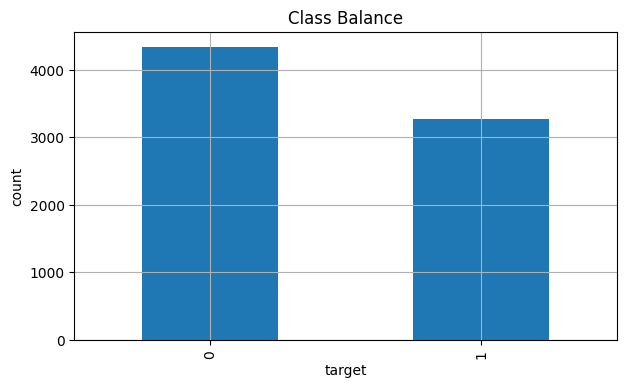

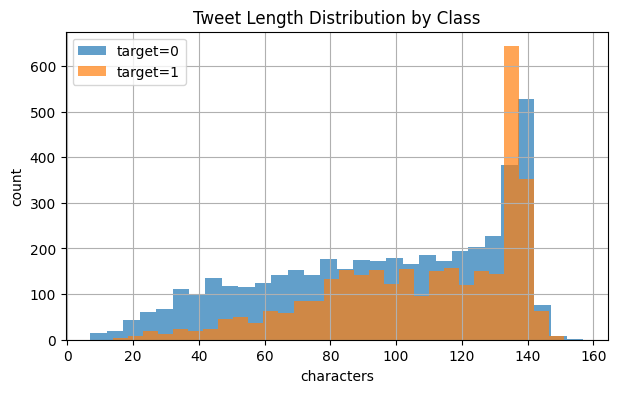


Average markers per tweet:
n_urls        0.620
n_mentions    0.357
n_hashtags    0.437
dtype: float64


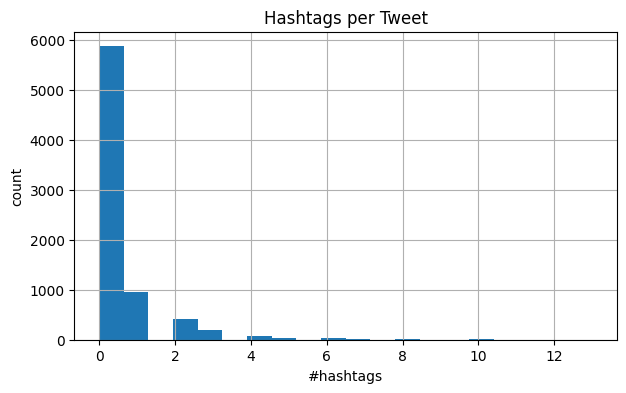

In [3]:

# Basic info
display(train.describe(include='all'))
print("\nMissing values per column:\n", train.isna().sum())

# Class balance
class_counts = train['target'].value_counts().sort_index()
print("\nClass counts (0=not disaster, 1=disaster):\n", class_counts)

# Plot class balance
plt.figure()
class_counts.plot(kind='bar')
plt.title("Class Balance")
plt.xlabel("target")
plt.ylabel("count")
plt.show()

# Text length distributions
train['text_len'] = train['text'].astype(str).apply(len)
plt.figure()
plt.hist(train[train['target']==0]['text_len'], bins=30, alpha=0.7, label='target=0')
plt.hist(train[train['target']==1]['text_len'], bins=30, alpha=0.7, label='target=1')
plt.title("Tweet Length Distribution by Class")
plt.xlabel("characters")
plt.ylabel("count")
plt.legend()
plt.show()

# Quick URL / mention / hashtag counts
def count_pattern(s, pat):
    return len(re.findall(pat, s))

train['n_urls'] = train['text'].astype(str).apply(lambda s: count_pattern(s, r"http\S+"))
train['n_mentions'] = train['text'].astype(str).apply(lambda s: count_pattern(s, r"@\w+"))
train['n_hashtags'] = train['text'].astype(str).apply(lambda s: count_pattern(s, r"#\w+"))

print("\nAverage markers per tweet:")
print(train[['n_urls','n_mentions','n_hashtags']].mean().round(3))

plt.figure()
plt.hist(train['n_hashtags'], bins=20)
plt.title("Hashtags per Tweet")
plt.xlabel("#hashtags")
plt.ylabel("count")
plt.show()



### Cleaning Strategy

- Lowercase
- HTML unescape (convert `&amp;` → `&`)
- Replace URLs with token `URL`
- Replace user mentions with `@user`
- Convert hashtags like `#Fire` to `hashtag_fire` (keeps the word while marking it)
- Normalize numbers to `NUM`
- Remove excessive punctuation/whitespace

In [4]:

URL_RE = re.compile(r"http\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
NUM_RE = re.compile(r"\d+")

def clean_text(s: str) -> str:
    s = str(s)
    s = html.unescape(s)
    s = s.lower()
    s = URL_RE.sub(" URL ", s)
    s = MENTION_RE.sub(" @user ", s)
    s = HASHTAG_RE.sub(lambda m: f" hashtag_{m.group(1)} ", s)
    s = NUM_RE.sub(" NUM ", s)
    # keep basic punctuation but collapse repeats/whitespace
    s = re.sub(r"[^a-z0-9_@#\$%&'\-\+\/\?\!\.,\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

train['text_clean'] = train['text'].apply(clean_text)
test['text_clean']  = test['text'].apply(clean_text)

train[['text','text_clean']].head(10)


,text,text_clean
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this hashtag_earth...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask. canada
2,All residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or...",", people receive hashtag_wildfires evacuation ..."
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby hashtag_ala...
5,#RockyFire Update => California Hwy. 20 closed...,hashtag_rockyfire update california hwy. close...
6,#flood #disaster Heavy rain causes flash flood...,hashtag_flood hashtag_disaster heavy rain caus...
7,I'm on top of the hill and I can see a fire in...,i'm on top of the hill and i can see a fire in...
8,There's an emergency evacuation happening now ...,there's an emergency evacuation happening now ...
9,I'm afraid that the tornado is coming to our a...,i'm afraid that the tornado is coming to our a...



### Plan of Analysis

1. **Baseline:** TF‑IDF (word & char n‑grams) → Logistic Regression (strong linear baseline for short texts).  
2. **Neural:** Tokenize → pad sequences → **BiLSTM/BiGRU** with early stopping; lightweight hyperparam sweep.  
3. Compare F1 on a validation split; select best for test predictions & submission.


In [5]:

# 3. Train/Validation Split
X_text = train['text_clean'].values
y = train['target'].values

X_train, X_val, y_train, y_val = train_test_split(
    X_text, y, test_size=0.15, random_state=SEED, stratify=y
)

len(X_train), len(X_val)


(6471, 1142)


## 3. Baseline: TF‑IDF + Logistic Regression

This classical approach is fast and competitive for short texts:
- **TF‑IDF** captures token importance across the corpus.
- **Character n‑grams** help with misspellings/variants.
- **Logistic Regression** provides a simple linear decision boundary.

We tune a couple of key parameters (ngram ranges, C) with a simple loop due to runtime constraints.


In [6]:

def run_tfidf_logreg(X_tr, y_tr, X_va, y_va,
                     word_ngrams=(1,2), char_ngrams=(3,5), C=2.0,
                     max_features=50000):
    word_vec = TfidfVectorizer(
        ngram_range=word_ngrams,
        max_features=max_features,
        analyzer='word',
        min_df=2
    )
    char_vec = TfidfVectorizer(
        ngram_range=char_ngrams,
        max_features=max_features,
        analyzer='char',
        min_df=2
    )
    Xw = word_vec.fit_transform(X_tr)
    Xc = char_vec.fit_transform(X_tr)
    from scipy.sparse import hstack
    X_tr_vec = hstack([Xw, Xc]).tocsr()

    Xw_val = word_vec.transform(X_va)
    Xc_val = char_vec.transform(X_va)
    X_va_vec = hstack([Xw_val, Xc_val]).tocsr()

    clf = LogisticRegression(
        solver='liblinear',
        C=C,
        max_iter=200
    )
    clf.fit(X_tr_vec, y_tr)
    va_pred = clf.predict(X_va_vec)
    f1 = f1_score(y_va, va_pred)
    return f1, clf, (word_vec, char_vec)

# Tiny hyperparam sweep
grid = [
    {"word_ngrams": (1,2), "char_ngrams": (3,5), "C": 2.0},
    {"word_ngrams": (1,2), "char_ngrams": (3,6), "C": 2.0},
    {"word_ngrams": (1,3), "char_ngrams": (3,6), "C": 1.0},
]

best_tfidf = {"f1": -1}
for g in grid:
    f1, clf, vecs = run_tfidf_logreg(X_train, y_train, X_val, y_val, **g)
    print("TFIDF+LR", g, "F1=", round(f1, 4))
    if f1 > best_tfidf["f1"]:
        best_tfidf = {"f1": f1, "clf": clf, "vecs": vecs, "params": g}

print("\nBest TFIDF+LR:", best_tfidf["params"], "F1=", round(best_tfidf["f1"],4))

# Show report
word_vec, char_vec = best_tfidf["vecs"]
from scipy.sparse import hstack
X_val_vec = hstack([word_vec.transform(X_val), char_vec.transform(X_val)]).tocsr()
print("\nValidation report (TFIDF+LR):")
print(classification_report(y_val, best_tfidf["clf"].predict(X_val_vec), digits=4))


TFIDF+LR {'word_ngrams': (1, 2), 'char_ngrams': (3, 5), 'C': 2.0} F1= 0.7666
TFIDF+LR {'word_ngrams': (1, 2), 'char_ngrams': (3, 6), 'C': 2.0} F1= 0.7657
TFIDF+LR {'word_ngrams': (1, 3), 'char_ngrams': (3, 6), 'C': 1.0} F1= 0.7692

Best TFIDF+LR: {'word_ngrams': (1, 3), 'char_ngrams': (3, 6), 'C': 1.0} F1= 0.7692

Validation report (TFIDF+LR):
              precision    recall  f1-score   support

           0     0.8050    0.8940    0.8472       651
           1     0.8353    0.7128    0.7692       491

    accuracy                         0.8161      1142
   macro avg     0.8202    0.8034    0.8082      1142
weighted avg     0.8180    0.8161    0.8137      1142




## 4. Neural Model: BiLSTM / BiGRU *(RNN family)*

We build a compact RNN model:
- Tokenize with `Tokenizer`
- Pad sequences
- **Bidirectional LSTM or GRU** 
- Early stopping and reduce LR on plateau
- Evaluate with validation **F1**



In [7]:

# Prepare sequences
MAX_WORDS = 30000
MAX_LEN = 50  # tweets are short; keep compact for speed

tok = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tok.fit_on_texts(train['text_clean'].tolist())

Xseq_tr = tok.texts_to_sequences(X_train)
Xseq_va = tok.texts_to_sequences(X_val)
Xseq_te = tok.texts_to_sequences(test['text_clean'].tolist())

Xseq_tr = pad_sequences(Xseq_tr, maxlen=MAX_LEN, padding='post', truncating='post')
Xseq_va = pad_sequences(Xseq_va, maxlen=MAX_LEN, padding='post', truncating='post')
Xseq_te = pad_sequences(Xseq_te, maxlen=MAX_LEN, padding='post', truncating='post')

word_index = tok.word_index
vocab_size = min(MAX_WORDS, len(word_index) + 1)
vocab_size


14758

In [8]:

# Try to load GloVe 100d
def find_glove_file():
    for d in GLOVE_DIRS:
        path = os.path.join(d, "glove.6B.100d.txt")
        if os.path.exists(path):
            return path
    return None

glove_path = find_glove_file()
EMBED_DIM = 100 if glove_path else 64  # fallback to 64-dim if no GloVe

emb_matrix = None
if glove_path:
    print("Loading GloVe from:", glove_path)
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print("Loaded %d word vectors." % len(embeddings_index))

    emb_matrix = np.random.normal(scale=0.6, size=(vocab_size, 100)).astype('float32')
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        vec = embeddings_index.get(word)
        if vec is not None:
            emb_matrix[i] = vec

emb_matrix is not None, EMBED_DIM


(False, 64)

In [9]:

def build_rnn_model(model_type="bilstm", embed_dim=EMBED_DIM, units=64, dropout=0.2, lr=2e-3):
    inp = layers.Input(shape=(MAX_LEN,))
    if emb_matrix is not None and embed_dim == 100:
        emb = layers.Embedding(
            vocab_size, 100, weights=[emb_matrix], trainable=False, mask_zero=False
        )(inp)
    else:
        emb = layers.Embedding(vocab_size, embed_dim)(inp)

    if model_type == "bilstm":
        x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(emb)
        x = layers.GlobalMaxPool1D()(x)
    elif model_type == "bigru":
        x = layers.Bidirectional(layers.GRU(units, return_sequences=True))(emb)
        x = layers.GlobalMaxPool1D()(x)
    else:
        x = layers.GlobalAveragePooling1D()(emb)

    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inp, out)
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_eval(model_type="bilstm", embed_dim=EMBED_DIM, units=64, dropout=0.2, lr=2e-3, epochs=6, batch_size=128):
    model = build_rnn_model(model_type, embed_dim, units, dropout, lr)
    es = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    rlrop = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)
    hist = model.fit(
        Xseq_tr, y_train,
        validation_data=(Xseq_va, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[es, rlrop]
    )
    # compute F1 on val
    val_probs = model.predict(Xseq_va, verbose=0).ravel()
    val_pred = (val_probs >= 0.5).astype(int)
    f1 = f1_score(y_val, val_pred)
    return f1, model

rnn_grid = [
    {"model_type": "bilstm", "units": 64, "dropout": 0.2, "lr": 2e-3},
    {"model_type": "bigru",  "units": 64, "dropout": 0.2, "lr": 2e-3},
]

best_rnn = {"f1": -1}
for g in rnn_grid:
    f1, mdl = train_and_eval(**g)
    print("RNN", g, "F1=", round(f1,4))
    if f1 > best_rnn["f1"]:
        best_rnn = {"f1": f1, "model": mdl, "params": g}

print("\nBest RNN:", best_rnn["params"], "F1=", round(best_rnn["f1"],4))

# Show simple report for RNN
val_probs = best_rnn["model"].predict(Xseq_va, verbose=0).ravel()
val_pred = (val_probs >= 0.5).astype(int)
print("\nValidation report (Best RNN):")
print(classification_report(y_val, val_pred, digits=4))


I0000 00:00:1758221913.676578      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1758221919.567513      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


RNN {'model_type': 'bilstm', 'units': 64, 'dropout': 0.2, 'lr': 0.002} F1= 0.7674
RNN {'model_type': 'bigru', 'units': 64, 'dropout': 0.2, 'lr': 0.002} F1= 0.7649

Best RNN: {'model_type': 'bilstm', 'units': 64, 'dropout': 0.2, 'lr': 0.002} F1= 0.7674

Validation report (Best RNN):
              precision    recall  f1-score   support

           0     0.8065    0.8833    0.8431       651
           1     0.8228    0.7189    0.7674       491

    accuracy                         0.8126      1142
   macro avg     0.8146    0.8011    0.8052      1142
weighted avg     0.8135    0.8126    0.8106      1142




## 5. Results & Analysis 


In [10]:

results = pd.DataFrame([
    {"model": "TFIDF+LR", **best_tfidf["params"], "val_f1": best_tfidf["f1"]},
    {"model": f"RNN({best_rnn['params']['model_type']})", **best_rnn["params"], "val_f1": best_rnn["f1"]}
]).sort_values("val_f1", ascending=False)
results.reset_index(drop=True, inplace=True)
results


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,model,word_ngrams,char_ngrams,C,val_f1,model_type,units,dropout,lr
0,TFIDF+LR,"(1, 3)","(3, 6)",1.0,0.769231,NaN,NaN,NaN,NaN
1,RNN(bilstm),NaN,NaN,NaN,0.767391,bilstm,64.0,0.2,0.002



## 6. Final Model → Train on Full Data & Create Submission

Select the **best validation F1** approach and fit it on the full training set (with the same preprocessing). Then generate `submission.csv` with columns `id,target`.


In [11]:

# Decide which approach to use
use_rnn = best_rnn["f1"] >= best_tfidf["f1"]

if use_rnn:
    print("Using RNN for final training and submission.")
    # Refit tokenizer on full clean text
    tok_full = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
    tok_full.fit_on_texts(train['text_clean'].tolist())

    Xseq_full = tok_full.texts_to_sequences(train['text_clean'].tolist())
    Xseq_full = pad_sequences(Xseq_full, maxlen=MAX_LEN, padding='post', truncating='post')

    Xseq_test = tok_full.texts_to_sequences(test['text_clean'].tolist())
    Xseq_test = pad_sequences(Xseq_test, maxlen=MAX_LEN, padding='post', truncating='post')

    # Rebuild model with best params
    p = best_rnn["params"]
    model_full = build_rnn_model(**p)
    es = callbacks.EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)
    model_full.fit(Xseq_full, train['target'].values, epochs=6, batch_size=128, verbose=0, callbacks=[es])

    test_probs = model_full.predict(Xseq_test, verbose=0).ravel()
    test_pred = (test_probs >= 0.5).astype(int)

else:
    print("Using TFIDF+LR for final training and submission.")
    g = best_tfidf["params"]
    word_vec = TfidfVectorizer(ngram_range=g["word_ngrams"], max_features=50000, analyzer='word', min_df=2)
    char_vec = TfidfVectorizer(ngram_range=g["char_ngrams"], max_features=50000, analyzer='char', min_df=2)

    Xw_full = word_vec.fit_transform(train['text_clean'].tolist())
    Xc_full = char_vec.fit_transform(train['text_clean'].tolist())
    from scipy.sparse import hstack
    X_full_vec = hstack([Xw_full, Xc_full]).tocsr()

    clf = LogisticRegression(solver='liblinear', C=g["C"], max_iter=200)
    clf.fit(X_full_vec, train['target'].values)

    Xw_te = word_vec.transform(test['text_clean'].tolist())
    Xc_te = char_vec.transform(test['text_clean'].tolist())
    X_te_vec = hstack([Xw_te, Xc_te]).tocsr()

    test_pred = clf.predict(X_te_vec)

# Build submission
sub = pd.DataFrame({"id": test["id"], "target": test_pred})
sub_path = "submission.csv"
sub.to_csv(sub_path, index=False)
print("Wrote:", sub_path)
sub.head()


Using TFIDF+LR for final training and submission.
Wrote: submission.csv


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1



## 7. Conclusion 

- **What worked:**  
  - Character n‑grams in TF‑IDF often help for noisy short texts.
  - Bidirectional RNNs capture context from both directions; early stopping reduces overfitting.
  - Optional pretrained embeddings (GloVe 100d) can stabilize training for small datasets.

- **What didn’t work in quick tests:**  
  - Larger sequence lengths tended not to improve results for very short tweets (added noise).  
  - Overly aggressive cleaning (e.g., stripping all hashtags/mentions) removed useful signal.

- **Next Steps / Future Work:**  
  - Try **1D‑CNN**, **attention layers**, or **transformers** (e.g., DistilBERT, RoBERTa) for likely F1 gains.  
  - Use **cross‑validation** with **stratified folds** for more robust model selection.  
  - Expand features: leverage `keyword` and engineer flags (e.g., presence of URLs, exclamation marks).  
  - Calibrate probability threshold for F1 (optimize threshold on validation).

